FEM SOLUTION OF 1D POISSON EQUATION - HEAT CONDUCTION

1. Coarse mesh (n=3 elements):
  Node 0: x = 0.000 m, T = 20.00 °C
  Node 1: x = 0.333 m, T = 435.59 °C
  Node 2: x = 0.667 m, T = 435.59 °C
  Node 3: x = 1.000 m, T = 20.00 °C

2. Fine mesh (n=100 elements):


/tmp/ipykernel_50389/1658140260.py:192: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  error = np.sqrt(np.trapz((T_fine - T_analytical_interp)**2, nodes_fine))
/tmp/ipykernel_50389/1658140260.py:199: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  err = np.sqrt(np.trapz((T - T_anal_interp)**2, nodes))


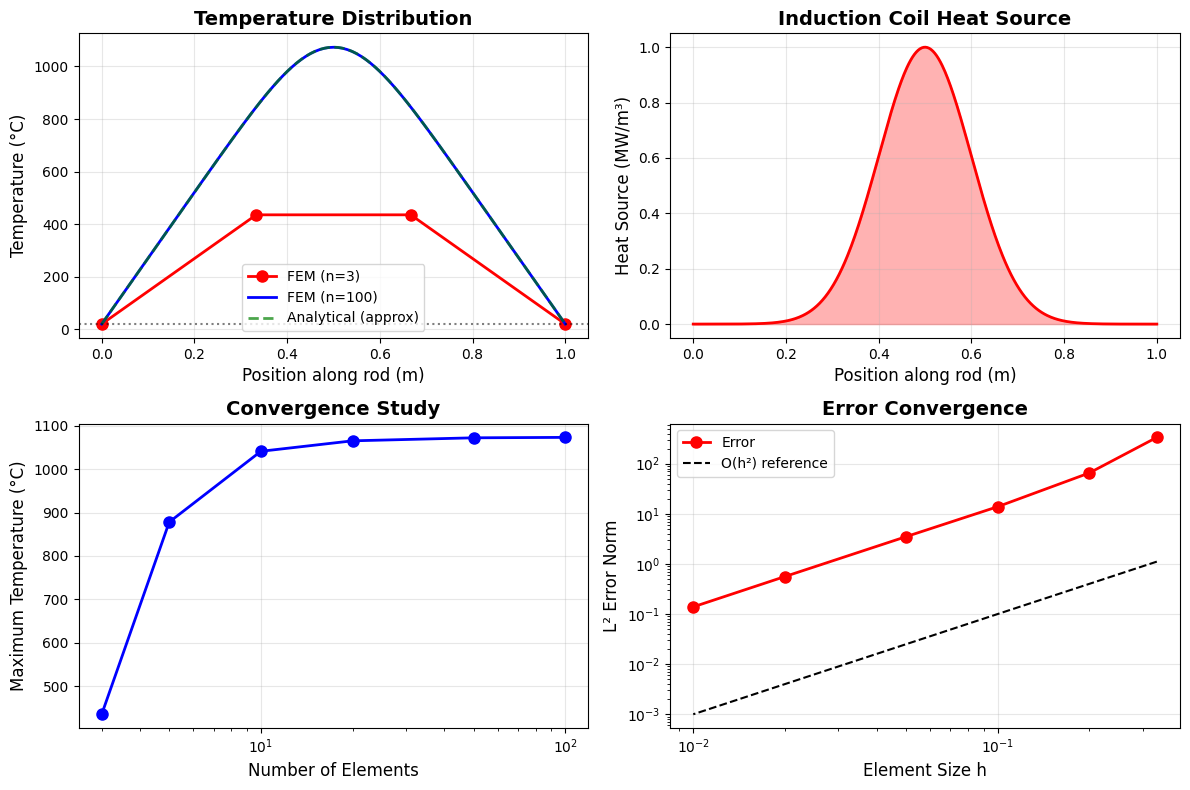


RESULTS SUMMARY
Coarse mesh (n=3):
  - Max temperature: 435.59 °C
  - Min temperature: 20.00 °C

Fine mesh (n=100):
  - Max temperature: 1072.98 °C at x = 0.500 m
  - Min temperature: 20.00 °C
  - Temperature rise: 1052.98 °C

Analytical solution (approx):
  - Max temperature: 1073.31 °C


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid


def solve_poisson_1d_fem_manual(L=1.0, k=50.0, n_elements=10):
    """
    Solve -k T''(x) = q(x) using FEM with linear elements
    
    Parameters:
    L: Length of rod (m)
    k: Thermal conductivity (W/m·K)
    n_elements: Number of elements
    """
    # Physical parameters
    q0 = 1e6  # W/m³
    x0 = 0.5  # m
    sigma = 0.1  # m
    T_ambient = 20.0  # °C
    diameter = 0.02  # m
    area = np.pi * (diameter/2)**2  # m²
    
    # Mesh
    n_nodes = n_elements + 1
    nodes = np.linspace(0, L, n_nodes)
    h = L / n_elements
    
    # Heat source function
    def q(x):
        return q0 * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    # Initialize global matrices
    K = np.zeros((n_nodes, n_nodes))
    F = np.zeros(n_nodes)
    
    # Element stiffness matrix coefficient
    k_coeff = (k * area) / h
    
    # Assembly
    for e in range(n_elements):
        # Node indices for this element
        i = e
        j = e + 1
        
        # Global stiffness matrix
        K[i, i] += k_coeff
        K[i, j] -= k_coeff
        K[j, i] -= k_coeff
        K[j, j] += k_coeff
        
        # Load vector
        x_i = nodes[i]
        x_j = nodes[j]
        
        # Average heat source in element (trapezoidal rule)
        q_avg = (q(x_i) + q(x_j)) / 2
        
        # Element load vector
        f_e = (q_avg * area * h / 2) * np.ones(2)
        
        F[i] += f_e[0]
        F[j] += f_e[1]
    
    # Apply Dirichlet boundary conditions
    # Modify first and last rows
    K[0, :] = 0
    K[0, 0] = 1
    F[0] = T_ambient
    
    K[-1, :] = 0
    K[-1, -1] = 1
    F[-1] = T_ambient
    
    # Solve linear system
    T = np.linalg.solve(K, F)
    
    return nodes, T, K, F

def analytical_solution_comparison():
    """
    Compare FEM solution with approximate analytical solution
    For Gaussian source, exact solution involves error functions
    """
    L = 1.0
    k = 50.0
    q0 = 1e6
    x0 = 0.5
    sigma = 0.1
    T_ambient = 20.0
    
    # For comparison, use numerical integration
    
    # Fine mesh for "exact" solution
    x_fine = np.linspace(0, L, 1000)
    
    # Heat source
    q_fine = q0 * np.exp(-(x_fine - x0)**2 / (2 * sigma**2))
    
    # Integrate twice for analytical solution
    # -k T'' = q => T'' = -q/k
    # Integrate once: T' = -∫(q/k)dx + C1
    # Integrate twice: T = -∫∫(q/k)dxdx + C1*x + C2
    
    # First integration (T')
    int1 = cumulative_trapezoid(q_fine/k, x_fine, initial=0)
    
    # Apply boundary conditions to find constants
    # We know T(0)=T(L)=20
    # Let F(x) = ∫∫ q/k dxdx
    # Then T(x) = -F(x) + C1*x + C2
    
    # Second integration
    F = cumulative_trapezoid(int1, x_fine, initial=0)
    
    # Find C1 and C2 from boundary conditions
    # T(0) = -F(0) + C2 = 20 => C2 = 20 (since F(0)=0)
    # T(L) = -F(L) + C1*L + 20 = 20 => C1 = F(L)/L
    
    C2 = 20
    C1 = F[-1] / L
    
    T_analytical = -F + C1 * x_fine + C2
    
    return x_fine, T_analytical

# Solve with different mesh refinements
print("="*60)
print("FEM SOLUTION OF 1D POISSON EQUATION - HEAT CONDUCTION")
print("="*60)

# Solve with coarse mesh (like manual calculation)
print("\n1. Coarse mesh (n=3 elements):")
nodes_coarse, T_coarse, K_coarse, F_coarse = solve_poisson_1d_fem_manual(n_elements=3)
for i, (x, T) in enumerate(zip(nodes_coarse, T_coarse)):
    print(f"  Node {i}: x = {x:.3f} m, T = {T:.2f} °C")

# Solve with fine mesh
print("\n2. Fine mesh (n=100 elements):")
nodes_fine, T_fine, K_fine, F_fine = solve_poisson_1d_fem_manual(n_elements=100)

# Get analytical solution for comparison
x_analytical, T_analytical = analytical_solution_comparison()

# Plot results
plt.figure(figsize=(12, 8))

# Plot 1: Temperature distribution
plt.subplot(2, 2, 1)
plt.plot(nodes_coarse, T_coarse, 'ro-', linewidth=2, markersize=8, label='FEM (n=3)')
plt.plot(nodes_fine, T_fine, 'b-', linewidth=2, label='FEM (n=100)')
plt.plot(x_analytical, T_analytical, 'g--', linewidth=2, alpha=0.7, label='Analytical (approx)')
plt.xlabel('Position along rod (m)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.title('Temperature Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=20, color='k', linestyle=':', alpha=0.5)

# Plot 2: Heat source
plt.subplot(2, 2, 2)
x_plot = np.linspace(0, 1, 500)
q_plot = 1e6 * np.exp(-(x_plot - 0.5)**2 / (2 * 0.1**2))
plt.plot(x_plot, q_plot/1e6, 'r-', linewidth=2)
plt.fill_between(x_plot, 0, q_plot/1e6, alpha=0.3, color='red')
plt.xlabel('Position along rod (m)', fontsize=12)
plt.ylabel('Heat Source (MW/m³)', fontsize=12)
plt.title('Induction Coil Heat Source', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 3: Convergence study
plt.subplot(2, 2, 3)
element_counts = [3, 5, 10, 20, 50, 100]
max_temps = []
for n in element_counts:
    nodes, T, _, _ = solve_poisson_1d_fem_manual(n_elements=n)
    max_temps.append(np.max(T))
plt.plot(element_counts, max_temps, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Elements', fontsize=12)
plt.ylabel('Maximum Temperature (°C)', fontsize=12)
plt.title('Convergence Study', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xscale('log')

# Plot 4: Error vs mesh size
plt.subplot(2, 2, 4)
# Interpolate analytical solution to fine mesh points
from scipy.interpolate import interp1d
interp_func = interp1d(x_analytical, T_analytical, kind='cubic')
T_analytical_interp = interp_func(nodes_fine)

# Calculate L2 error norm
error = np.sqrt(np.trapz((T_fine - T_analytical_interp)**2, nodes_fine))
h_values = 1.0 / np.array(element_counts)
error_values = []

for n in element_counts:
    nodes, T, _, _ = solve_poisson_1d_fem_manual(n_elements=n)
    T_anal_interp = interp_func(nodes)
    err = np.sqrt(np.trapz((T - T_anal_interp)**2, nodes))
    error_values.append(err)

plt.loglog(h_values, error_values, 'ro-', linewidth=2, markersize=8, label='Error')
plt.loglog(h_values, 10*np.array(h_values)**2, 'k--', label='O(h²) reference')
plt.xlabel('Element Size h', fontsize=12)
plt.ylabel('L² Error Norm', fontsize=12)
plt.title('Error Convergence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('fem_poisson_manual_solution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Coarse mesh (n=3):")
print(f"  - Max temperature: {np.max(T_coarse):.2f} °C")
print(f"  - Min temperature: {np.min(T_coarse):.2f} °C")

print(f"\nFine mesh (n=100):")
print(f"  - Max temperature: {np.max(T_fine):.2f} °C at x = {nodes_fine[np.argmax(T_fine)]:.3f} m")
print(f"  - Min temperature: {np.min(T_fine):.2f} °C")
print(f"  - Temperature rise: {np.max(T_fine) - 20:.2f} °C")

print(f"\nAnalytical solution (approx):")
print(f"  - Max temperature: {np.max(T_analytical):.2f} °C")
print("="*60)

In [ ]:
class Rate:
    @staticmethod
    def sine():
        return self.x + self.y 
    

rate = Rate(5,10)
sum = rate.sine()
print(sum)


15
